# Load Data n Config

In [ ]:
# @title Step 1: Mount Google Drive & Config
from google.colab import drive
import os
import shutil

# 1. Mount drive
drive.mount('/content/drive')

# --- KONFIGURASI PATH ---
# Lokasi asli di Google Drive (Slow Access)
SOURCE_PATH = "/content/drive/MyDrive/Datasets/Javanese (various dialects)"

# Lokasi tujuan sementara di VM Colab (Fast Access)
WORK_DIR = "/content/dataset_paper_clean"

# Target Dialek (Sesuai nama folder)
SELECTED_DIALECTS = ["Banyumas", "Solo", "Malang"]

print(f"✅ Source Drive: {SOURCE_PATH}")
print(f"✅ Local Work Dir: {WORK_DIR}")
print(f"✅ Target Classes: {SELECTED_DIALECTS}")

Mounted at /content/drive
✅ Source Drive: /content/drive/MyDrive/Datasets/Javanese (various dialects)
✅ Local Work Dir: /content/dataset_paper_clean
✅ Target Classes: ['Banyumas', 'Solo', 'Malang']


In [ ]:
# @title Step 2: Copy Data to Local Colab + Cek File
import os
import shutil
from tqdm.notebook import tqdm

def copy_selected_data(source_root, dest_root, dialects):
    # Buat folder tujuan utama jika belum ada
    if not os.path.exists(dest_root):
        os.makedirs(dest_root)

    print("Memulai proses penyalinan data (Drive -> Local Colab)...")

    for dialect in dialects:
        src_path = os.path.join(source_root, dialect)
        dst_path = os.path.join(dest_root, dialect)

        # Cek apakah folder sumber ada
        if os.path.exists(src_path):
            if os.path.exists(dst_path):
                print(f"   ⚠️ Folder {dialect} sudah ada di local, skip copy.")
            else:
                # Copy folder dialek beserta isinya
                print(f"   📂 Copying {dialect}...")
                shutil.copytree(src_path, dst_path)
        else:
            print(f"   ❌ Warning: Folder sumber '{dialect}' tidak ditemukan di Drive!")

    print("\n✅ Proses penyalinan selesai!")
    print(f"Data siap diakses di: {dest_root}")

    # -----------------------------
    # Pengecekan folder & file
    # -----------------------------
    print("\n🔍 Memulai pengecekan file per folder...")
    for dialect in dialects:
        folder_path = os.path.join(dest_root, dialect)
        if os.path.exists(folder_path):
            # Hitung jumlah file .wav di folder termasuk subfolder
            total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
            print(f"   📁 {dialect} -> Folder ada, total file termasuk subfolder: {total_files}")
        else:
            print(f"   ❌ Folder {dialect} TIDAK ADA di local!")

# Eksekusi
copy_selected_data(SOURCE_PATH, WORK_DIR, SELECTED_DIALECTS)


Memulai proses penyalinan data (Drive -> Local Colab)...
   📂 Copying Banyumas...
   📂 Copying Solo...
   📂 Copying Malang...

✅ Proses penyalinan selesai!
Data siap diakses di: /content/dataset_paper_clean

🔍 Memulai pengecekan file per folder...
   📁 Banyumas -> Folder ada, total file termasuk subfolder: 18
   📁 Solo -> Folder ada, total file termasuk subfolder: 23
   📁 Malang -> Folder ada, total file termasuk subfolder: 12


In [ ]:
# @title Step 3: Load Metadata (Revised & Robust)
import glob
import pandas as pd
from pathlib import Path

def parse_local_dataset_robust(base_path, target_classes):
    data_records = []
    print(f"🔍 Mencari data di: {base_path}...")

    for region in target_classes:
        # Gunakan pathlib untuk pencarian recursive yang lebih mudah
        # Mencari semua file .wav di dalam folder region, sedalam apapun subfoldernya
        search_pattern = f"{base_path}/{region}/**/*.wav"
        wav_files = glob.glob(search_pattern, recursive=True)

        print(f"   -> {region}: ditemukan {len(wav_files)} file audio.")

        for file_path in wav_files:
            # Logika Group ID:
            # Ambil nama folder induk tempat file wav berada sebagai Group ID
            # Contoh: .../Banyumas/FOLDER_ACAK_123/audio.wav -> group_id = FOLDER_ACAK_123
            parent_folder = os.path.basename(os.path.dirname(file_path))

            # Jika file langsung di folder Banyumas (tanpa subfolder), group_id = nama file
            if parent_folder == region:
                group_id = os.path.basename(file_path)
            else:
                group_id = parent_folder

            data_records.append({
                'path': file_path,
                'label': region,
                'group_id': group_id
            })

    if not data_records:
        print("\n❌ FATAL ERROR: Tidak ada data yang terkumpul.")
        return pd.DataFrame() # Return empty DF

    return pd.DataFrame(data_records)

# Eksekusi fungsi baru
df_meta = parse_local_dataset_robust(WORK_DIR, SELECTED_DIALECTS)

# Cek sebelum print value_counts agar tidak KeyError lagi
if not df_meta.empty:
    print(f"\n✅ SUKSES: Total File Audio Terload: {len(df_meta)}")
    print("Distribusi Kelas:")
    print(df_meta['label'].value_counts())
    print("\nContoh Data:")
    print(df_meta.head(3))
else:
    print("\n⚠️ DataFrame kosong. Cek hasil debug di atas.")

🔍 Mencari data di: /content/dataset_paper_clean...
   -> Banyumas: ditemukan 18 file audio.
   -> Solo: ditemukan 23 file audio.
   -> Malang: ditemukan 12 file audio.

✅ SUKSES: Total File Audio Terload: 53
Distribusi Kelas:
label
Solo        23
Banyumas    18
Malang      12
Name: count, dtype: int64

Contoh Data:
                                                path     label  \
0  /content/dataset_paper_clean/Banyumas/JCBP-200...  Banyumas   
1  /content/dataset_paper_clean/Banyumas/JCBC-200...  Banyumas   
2  /content/dataset_paper_clean/Banyumas/JCBP-200...  Banyumas   

          group_id  
0   JCBP-20071017a  
1  JCBC-20060401-B  
2    JCBP-20070118  


In [ ]:
# @title Step 4: Feature Extraction (Save to Disk Strategy)
import librosa
import numpy as np
import os
import shutil
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

# --- CONFIG ---
CFG = {
    'sr': 16000,
    'duration': 3.0,
    'hop_length': 512,
    'n_fft': 2048,
    'n_mels': 128,
    'top_db': 20,
}

# Folder penyimpanan sementara fitur (Supaya RAM lega)
NPY_DIR = "/content/features_npy"
if os.path.exists(NPY_DIR):
    shutil.rmtree(NPY_DIR) # Bersihkan jika ada sisa run sebelumnya
os.makedirs(NPY_DIR, exist_ok=True)

SAMPLES_PER_SEGMENT = int(CFG['sr'] * CFG['duration'])
EXPECTED_FRAMES = int(np.ceil(SAMPLES_PER_SEGMENT / CFG['hop_length']))

def process_and_save(row):
    path = row['path']
    label = row['label']
    group_id = row['group_id']

    metadata_list = [] # Kita cuma simpan alamat file, bukan datanya

    try:
        y, sr = librosa.load(path, sr=CFG['sr'])
        y_trimmed, _ = librosa.effects.trim(y, top_db=CFG['top_db'])

        total_samples = len(y_trimmed)
        segment_idx = 0

        for start in range(0, total_samples, SAMPLES_PER_SEGMENT):
            end = start + SAMPLES_PER_SEGMENT
            if end > total_samples: break

            segment = y_trimmed[start:end]

            # Feature Extraction
            mels = librosa.feature.melspectrogram(
                y=segment, sr=sr, n_fft=CFG['n_fft'],
                hop_length=CFG['hop_length'], n_mels=CFG['n_mels']
            )
            log_mels = librosa.power_to_db(mels, ref=np.max)

            # Fix Dimensions
            if log_mels.shape[1] != EXPECTED_FRAMES:
                log_mels = log_mels[:, :EXPECTED_FRAMES]

            # Norm Min-Max
            min_val, max_val = log_mels.min(), log_mels.max()
            if (max_val - min_val) > 0:
                norm_mels = (log_mels - min_val) / (max_val - min_val)
            else:
                norm_mels = log_mels

            # Reshape (128, Time, 1)
            norm_mels = norm_mels[..., np.newaxis]

            # --- BAGIAN PENTING: SAVE KE DISK ---
            # Nama file unik
            file_name = f"{group_id}_{segment_idx}.npy"
            save_path = os.path.join(NPY_DIR, file_name)

            # Simpan array ke file
            np.save(save_path, norm_mels)

            # Catat metadata
            metadata_list.append({
                'npy_path': save_path,
                'label': label,
                'group_id': group_id
            })
            segment_idx += 1

    except Exception as e:
        print(f"Error: {e}")

    return metadata_list

# --- EKSEKUSI ---
all_segments_meta = []

print("🚀 Memproses audio dan menyimpan fitur ke disk...")
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
    meta = process_and_save(row)
    all_segments_meta.extend(meta)

# Buat DataFrame Segmen (Ringan, cuma teks)
df_segments = pd.DataFrame(all_segments_meta)

# Encode Label
le = LabelEncoder()
df_segments['label_encoded'] = le.fit_transform(df_segments['label'])

print("\n✅ SELESAI!")
print(f"Total Segmen Tersimpan: {len(df_segments)}")
print(f"Lokasi Fitur: {NPY_DIR}")
print(df_segments.head())

🚀 Memproses audio dan menyimpan fitur ke disk...


  0%|          | 0/53 [00:00<?, ?it/s]


✅ SELESAI!
Total Segmen Tersimpan: 39076
Lokasi Fitur: /content/features_npy
                                     npy_path     label        group_id  \
0  /content/features_npy/JCBP-20071017a_0.npy  Banyumas  JCBP-20071017a   
1  /content/features_npy/JCBP-20071017a_1.npy  Banyumas  JCBP-20071017a   
2  /content/features_npy/JCBP-20071017a_2.npy  Banyumas  JCBP-20071017a   
3  /content/features_npy/JCBP-20071017a_3.npy  Banyumas  JCBP-20071017a   
4  /content/features_npy/JCBP-20071017a_4.npy  Banyumas  JCBP-20071017a   

   label_encoded  
0              0  
1              0  
2              0  
3              0  
4              0  


In [ ]:
# @title Step 5: Data Generator & Model Architectures (COMPLETE)
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# --- 1. DATA GENERATOR (Supaya RAM Aman) ---
class NpyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Ambil index batch
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        # Ambil data dari dataframe
        batch_rows = self.df.iloc[indexes]
        # Load file dari disk
        X, y = self.__data_generation(batch_rows)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_rows):
        X = []
        y = []
        for _, row in batch_rows.iterrows():
            try:
                # Load file .npy
                img = np.load(row['npy_path'])
                X.append(img)
                y.append(row['label_encoded'])
            except:
                pass
        return np.array(X), np.array(y)

# --- 2. MODEL BASELINE (CNN) ---
def build_cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- 3. MODEL HYBRID (CNN-TCN) ---
def build_cnn_tcn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Reshape for TCN (Freq, Time, Filters) -> (Time, Features)
    x = layers.Permute((2, 1, 3))(x)
    target_shape = (x.shape[1], x.shape[2] * x.shape[3])
    x = layers.Reshape(target_shape)(x)

    # TCN Block
    def tcn_block(x, filters, kernel_size=3, dilation_rate=1):
        conv = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(conv)
        conv = layers.BatchNormalization()(conv)
        if x.shape[-1] != filters:
            x = layers.Conv1D(filters, 1, padding='same')(x)
        return layers.Add()([x, conv])

    for d in [1, 2, 4]:
        x = tcn_block(x, 128, dilation_rate=d)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- 4. SWITCH CONFIG ---
USE_HYBRID = True # Ganti ke True jika ingin Hybrid

if USE_HYBRID:
    print("🔔 Mode: HYBRID CNN-TCN Selected")
    model_builder = build_cnn_tcn_model
else:
    print("🔔 Mode: BASELINE CNN Selected")
    model_builder = build_cnn_model

print("✅ Data Generator & Model siap digunakan.")

🔔 Mode: HYBRID CNN-TCN Selected
✅ Data Generator & Model siap digunakan.


In [ ]:
# @title Step 6: Training with Detailed Logging (Updated)
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import tensorflow as tf

# --- CONFIG ---
N_FOLDS = 5
BATCH_SIZE = 64
EPOCHS = 15
VERBOSE = 1

sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Load Metadata
X_paths = df_segments['npy_path'].values
y_labels = df_segments['label_encoded'].values
groups = df_segments['group_id'].values

fold_results = []

print(f"⚔️ Memulai Cross-Validation ({N_FOLDS} Folds)...")
print(f"🧠 Model: {'Hybrid CNN-TCN' if USE_HYBRID else 'Baseline CNN'}")

for fold, (train_idx, val_idx) in enumerate(sgkf.split(X_paths, y_labels, groups)):
    print(f"\n🔄 FOLD {fold+1}/{N_FOLDS}")

    # Split
    df_train = df_segments.iloc[train_idx]
    df_val = df_segments.iloc[val_idx]

    train_gen = NpyDataGenerator(df_train, batch_size=BATCH_SIZE, shuffle=True)
    val_gen = NpyDataGenerator(df_val, batch_size=BATCH_SIZE, shuffle=False)

    # Weights
    train_y = df_train['label_encoded'].values
    classes = np.unique(train_y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y)
    class_weight_dict = dict(zip(classes, weights))

    # Model
    sample_file = df_train.iloc[0]['npy_path']
    input_shape = np.load(sample_file).shape
    model = model_builder(input_shape=input_shape, num_classes=len(classes))

    # Train
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        train_gen, validation_data=val_gen, epochs=EPOCHS,
        class_weight=class_weight_dict, callbacks=[early_stop], verbose=VERBOSE
    )

    # Predict
    y_pred_probs = model.predict(val_gen)
    y_pred_segment = np.argmax(y_pred_probs, axis=1)

    # Sync Labels
    y_true_segment = df_val['label_encoded'].values[:len(y_pred_segment)]
    val_groups_trimmed = df_val['group_id'].values[:len(y_pred_segment)]

    # 1. Segment Metrics
    f1_seg = f1_score(y_true_segment, y_pred_segment, average='macro')
    acc_seg = accuracy_score(y_true_segment, y_pred_segment)

    # 2. Speaker Metrics (Voting)
    eval_df = pd.DataFrame({'y_true': y_true_segment, 'y_pred': y_pred_segment, 'group_id': val_groups_trimmed})
    speaker_true, speaker_pred = [], []
    for _, grp_df in eval_df.groupby('group_id'):
        speaker_true.append(grp_df['y_true'].iloc[0])
        speaker_pred.append(Counter(grp_df['y_pred']).most_common(1)[0][0])

    f1_spk = f1_score(speaker_true, speaker_pred, average='macro')
    acc_spk = accuracy_score(speaker_true, speaker_pred)

    # 3. Confusion Matrix (Speaker Level)
    cm_spk = confusion_matrix(speaker_true, speaker_pred, labels=classes)

    print(f"📊 Fold {fold+1}: Seg F1={f1_seg:.4f} | Spk F1={f1_spk:.4f}")

    # SAVE EVERYTHING
    fold_results.append({
        'fold': fold+1,
        'f1_segment': f1_seg, 'acc_segment': acc_seg,
        'f1_speaker': f1_spk, 'acc_speaker': acc_spk,
        'history': history.history,  # <--- PENTING: Simpan history untuk grafik
        'cm_speaker': cm_spk         # <--- PENTING: Simpan CM untuk analisis
    })

# Save to variable
if USE_HYBRID:
    hybrid_results = fold_results
    print("\n✅ Hasil HYBRID tersimpan.")
else:
    baseline_results = fold_results
    print("\n✅ Hasil BASELINE tersimpan.")

⚔️ Memulai Cross-Validation (5 Folds)...
🧠 Model: Hybrid CNN-TCN

🔄 FOLD 1/5
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


488/488 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.8465 - loss: 0.4387 - val_accuracy: 0.6692 - val_loss: 1.4985
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9728 - loss: 0.0801 - val_accuracy: 0.7404 - val_loss: 1.0925
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9812 - loss: 0.0535 - val_accuracy: 0.7565 - val_loss: 1.1504
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9871 - loss: 0.0373 - val_accuracy: 0.8080 - val_loss: 1.0373
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9927 - loss: 0.0228 - val_accuracy: 0.8112 - val_loss: 0.8495
Epoch 6/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9904 - loss: 0.0299 - val_accuracy: 0.6255 - val_loss: 2.2871
Epoch 7/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9939 - loss: 0.0182 - val_accuracy: 0.8747 - val_loss: 0.5172
Epoch 8/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9937 - loss: 0.0175 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


492/492 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.8383 - loss: 0.4700 - val_accuracy: 0.6500 - val_loss: 1.6491
Epoch 2/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9634 - loss: 0.1145 - val_accuracy: 0.7247 - val_loss: 0.6802
Epoch 3/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9729 - loss: 0.0775 - val_accuracy: 0.5700 - val_loss: 1.7210
Epoch 4/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9837 - loss: 0.0481 - val_accuracy: 0.7610 - val_loss: 1.1412
Epoch 5/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9856 - loss: 0.0469 - val_accuracy: 0.6423 - val_loss: 2.1435
Epoch 6/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9884 - loss: 0.0367 - val_accuracy: 0.7824 - val_loss: 1.0493
Epoch 7/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9898 - loss: 0.0298 - val_accuracy: 0.7891 - val_loss: 0.8959
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
📊 Fold 2: Seg F1=0.7215 | Spk F1=0.8024

🔄 FOLD 3/5
Epoch 1

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


497/497 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.8198 - loss: 0.5456 - val_accuracy: 0.6330 - val_loss: 1.7220
Epoch 2/15
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9559 - loss: 0.1280 - val_accuracy: 0.6316 - val_loss: 1.3835
Epoch 3/15
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9752 - loss: 0.0731 - val_accuracy: 0.5626 - val_loss: 2.8427
Epoch 4/15
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9809 - loss: 0.0555 - val_accuracy: 0.7045 - val_loss: 1.5350
Epoch 5/15
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9875 - loss: 0.0392 - val_accuracy: 0.6802 - val_loss: 1.8529
Epoch 6/15
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9886 - loss: 0.0353 - val_accuracy: 0.8347 - val_loss: 0.6645
Epoch 7/15
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9874 - loss: 0.0409 - val_accuracy: 0.8418 - val_loss: 0.7196
Epoch 8/15
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9938 - loss: 0.0211 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


474/474 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.8405 - loss: 0.4869 - val_accuracy: 0.3980 - val_loss: 5.2714
Epoch 2/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9663 - loss: 0.0977 - val_accuracy: 0.4616 - val_loss: 7.1082
Epoch 3/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9759 - loss: 0.0699 - val_accuracy: 0.8354 - val_loss: 0.6665
Epoch 4/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9853 - loss: 0.0444 - val_accuracy: 0.8211 - val_loss: 0.5726
Epoch 5/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9875 - loss: 0.0384 - val_accuracy: 0.8509 - val_loss: 0.8103
Epoch 6/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9901 - loss: 0.0297 - val_accuracy: 0.7862 - val_loss: 0.8814
Epoch 7/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9935 - loss: 0.0218 - val_accuracy: 0.9457 - val_loss: 0.2833
Epoch 8/15
474/474 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9918 - loss: 0.0249 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


489/489 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.8270 - loss: 0.4754 - val_accuracy: 0.4241 - val_loss: 6.3510
Epoch 2/15
489/489 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9569 - loss: 0.1277 - val_accuracy: 0.6615 - val_loss: 2.2756
Epoch 3/15
489/489 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9720 - loss: 0.0748 - val_accuracy: 0.8191 - val_loss: 0.6192
Epoch 4/15
489/489 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9831 - loss: 0.0507 - val_accuracy: 0.7546 - val_loss: 1.1172
Epoch 5/15
489/489 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9822 - loss: 0.0487 - val_accuracy: 0.6699 - val_loss: 3.4235
Epoch 6/15
489/489 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9833 - loss: 0.0463 - val_accuracy: 0.7822 - val_loss: 1.5889
Epoch 7/15
489/489 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9909 - loss: 0.0257 - val_accuracy: 0.8147 - val_loss: 1.9446
Epoch 8/15
489/489 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9912 - loss: 0.0267 - val_accurac

=== TABEL 1: DETAIL PER FOLD ===

>>> Tabel Performa: Baseline CNN


,fold,f1_segment,acc_segment,f1_speaker,acc_speaker
0,1.0000,0.7724,0.8079,0.9221,0.9000
1,2.0000,0.7471,0.7393,0.8056,0.8000
2,3.0000,0.6763,0.8624,1.0000,1.0000
3,4.0000,0.5639,0.7675,0.5741,0.8182
4,5.0000,0.7731,0.8413,0.8519,0.9091
Mean,3.0000,0.7066,0.8037,0.8307,0.8855
Std,1.5811,0.0890,0.0509,0.1612,0.0802



>>> Tabel Performa: Hybrid CNN-TCN


,fold,f1_segment,acc_segment,f1_speaker,acc_speaker
0,1.0000,0.8311,0.8747,1.0000,1.0000
1,2.0000,0.7215,0.7247,0.8024,0.8000
2,3.0000,0.6589,0.8347,1.0000,1.0000
3,4.0000,0.7698,0.9457,0.6364,0.9091
4,5.0000,0.6707,0.8191,0.5741,0.8182
Mean,3.0000,0.7304,0.8398,0.8026,0.9055
Std,1.5811,0.0715,0.0808,0.1986,0.0957



=== GAMBAR 1: LEARNING CURVES ===


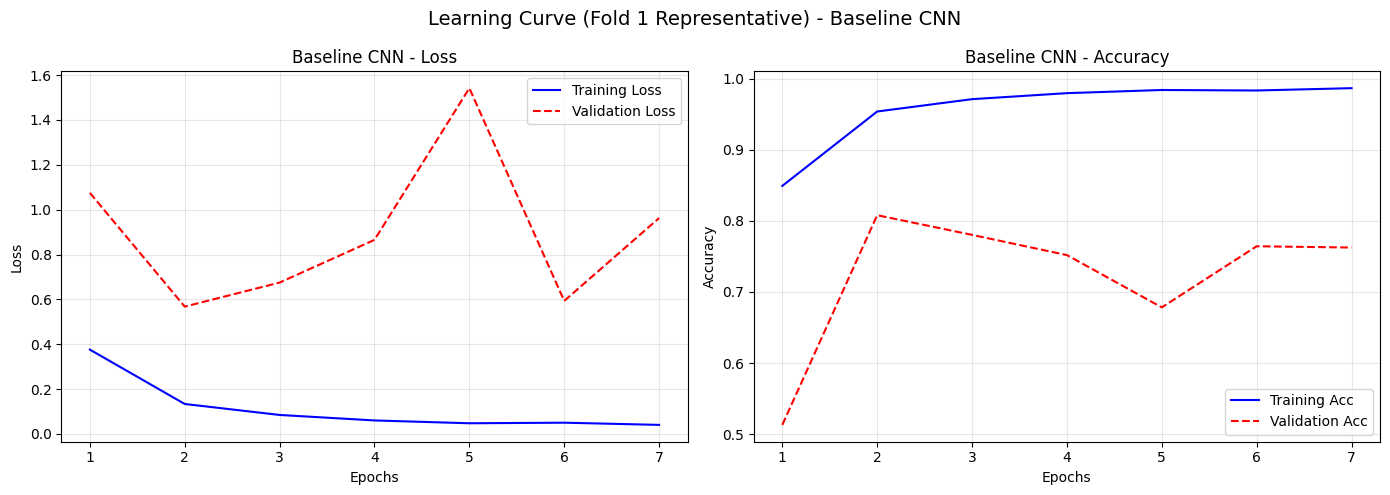

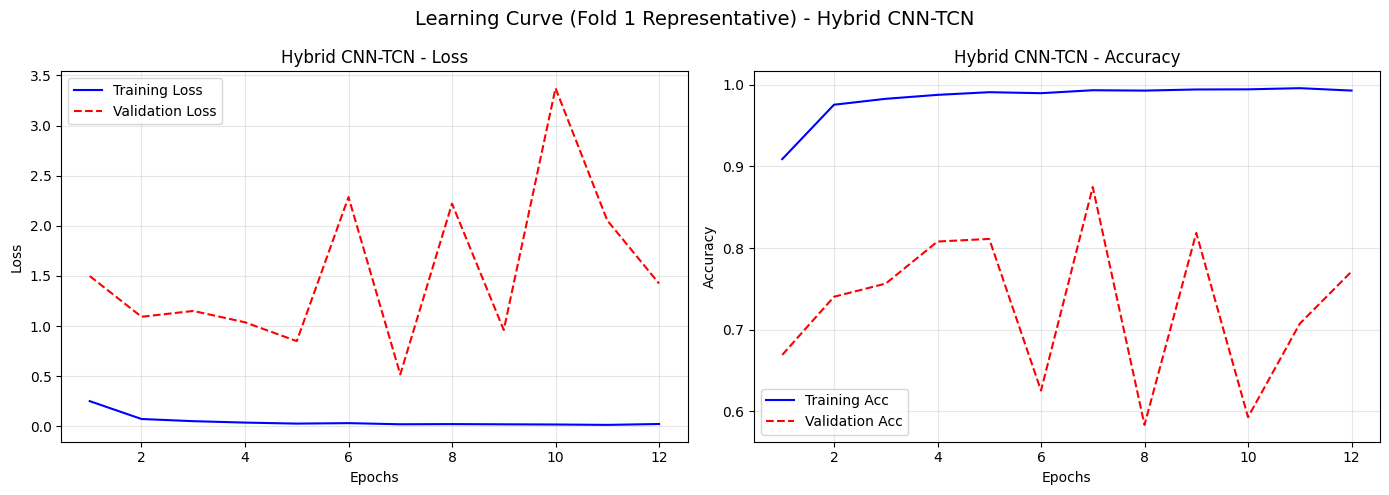


=== GAMBAR 2: PERBANDINGAN MODEL ===


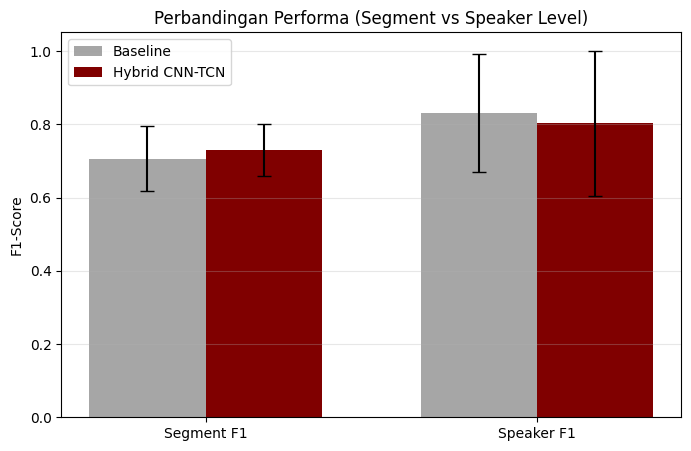


=== GAMBAR 3: MATRIKS KONFUSI (SPEAKER LEVEL) ===


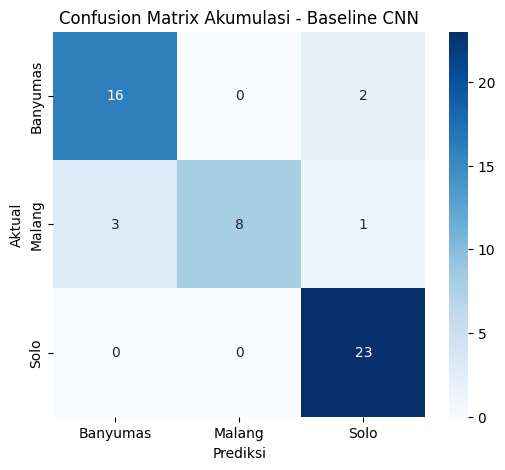

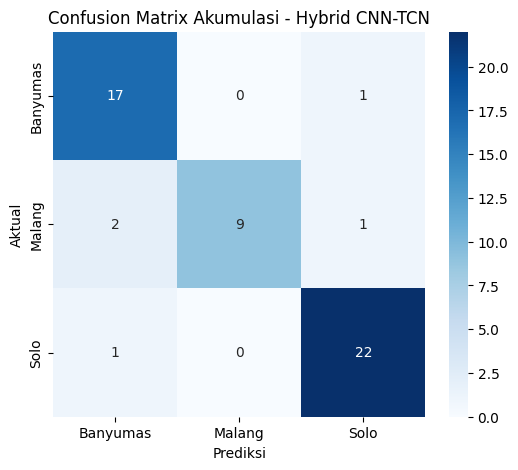

In [ ]:
# @title Step 7: Generate Complete Analysis (Tables & Figures)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Pastikan data ada
if 'baseline_results' not in globals() or 'hybrid_results' not in globals():
    print("⚠️ Harap jalankan Step 6 untuk kedua model (Baseline & Hybrid) terlebih dahulu!")
else:
    # --- A. TABEL 1 & 2: PERFORMA STATISTIK ---
    def create_summary_table(results, model_name):
        df = pd.DataFrame(results)
        df = df[['fold', 'f1_segment', 'acc_segment', 'f1_speaker', 'acc_speaker']]
        # Tambah baris rata-rata
        mean_row = df.mean(numeric_only=True)
        std_row = df.std(numeric_only=True)
        df.loc['Mean'] = mean_row
        df.loc['Std'] = std_row
        print(f"\n>>> Tabel Performa: {model_name}")
        display(df.round(4))
        return mean_row, std_row

    print("=== TABEL 1: DETAIL PER FOLD ===")
    base_mean, base_std = create_summary_table(baseline_results, "Baseline CNN")
    hyb_mean, hyb_std = create_summary_table(hybrid_results, "Hybrid CNN-TCN")

    # --- B. GAMBAR 1: LEARNING CURVES ---
    def plot_learning_curve(results, title):
        loss_train = []
        loss_val = []
        acc_train = []
        acc_val = []

        # Ambil rata-rata per epoch dari semua fold (handling panjang epoch beda)
        # Untuk simplifikasi, kita plot Fold 1 saja sebagai representasi
        hist = results[0]['history']
        epochs = range(1, len(hist['loss']) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Loss
        ax1.plot(epochs, hist['loss'], 'b-', label='Training Loss')
        ax1.plot(epochs, hist['val_loss'], 'r--', label='Validation Loss')
        ax1.set_title(f'{title} - Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy
        ax2.plot(epochs, hist['accuracy'], 'b-', label='Training Acc')
        ax2.plot(epochs, hist['val_accuracy'], 'r--', label='Validation Acc')
        ax2.set_title(f'{title} - Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.suptitle(f"Learning Curve (Fold 1 Representative) - {title}", fontsize=14)
        plt.tight_layout()
        plt.show()

    print("\n=== GAMBAR 1: LEARNING CURVES ===")
    plot_learning_curve(baseline_results, "Baseline CNN")
    plot_learning_curve(hybrid_results, "Hybrid CNN-TCN")

    # --- C. GAMBAR 2: MODEL COMPARISON BAR CHART (LENGKAP) ---
    # Kita bandingkan 4 metrik sekaligus
    metrics = ['Segment F1', 'Segment Acc', 'Speaker F1', 'Speaker Acc']

    # Ambil nilai Mean dari hasil perhitungan sebelumnya
    base_scores = [
        base_mean['f1_segment'], base_mean['acc_segment'],
        base_mean['f1_speaker'], base_mean['acc_speaker']
    ]
    hyb_scores = [
        hyb_mean['f1_segment'], hyb_mean['acc_segment'],
        hyb_mean['f1_speaker'], hyb_mean['acc_speaker']
    ]

    # Ambil nilai Std Dev untuk Error Bars
    base_err = [
        base_std['f1_segment'], base_std['acc_segment'],
        base_std['f1_speaker'], base_std['acc_speaker']
    ]
    hyb_err = [
        hyb_std['f1_segment'], hyb_std['acc_segment'],
        hyb_std['f1_speaker'], hyb_std['acc_speaker']
    ]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6)) # Ukuran agak lebar biar lega

    # Plotting Bar
    rects1 = ax.bar(x - width/2, base_scores, width, yerr=base_err, label='Baseline CNN', capsize=5, color='gray', alpha=0.8)
    rects2 = ax.bar(x + width/2, hyb_scores, width, yerr=hyb_err, label='Hybrid CNN-TCN', capsize=5, color='maroon')

    # Dekorasi Grafik
    ax.set_ylabel('Score (0.0 - 1.0)')
    ax.set_title('Perbandingan Performa Lengkap (F1 vs Accuracy)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend(loc='lower right') # Taruh legend di bawah biar gak nutupin
    ax.set_ylim(0, 1.15) # Kasih ruang di atas biar angka gak kepotong
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Fungsi nambahin angka di atas batang
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)

    print("\n=== GAMBAR 2: PERBANDINGAN MODEL (F1 & ACCURACY) ===")
    plt.tight_layout()
    plt.show()

    # --- D. GAMBAR 3 & TABEL 3: CONFUSION MATRIX ---
    def plot_accumulated_cm(results, title, class_names):
        # Jumlahkan CM dari semua fold
        total_cm = np.sum([r['cm_speaker'] for r in results], axis=0)

        plt.figure(figsize=(6, 5))
        sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Prediksi')
        plt.ylabel('Aktual')
        plt.title(f'Confusion Matrix Akumulasi - {title}')
        plt.show()
        return total_cm

    # Ambil nama kelas dari LabelEncoder (Step 4)
    class_names = le.classes_

    print("\n=== GAMBAR 3: MATRIKS KONFUSI (SPEAKER LEVEL) ===")
    cm_base = plot_accumulated_cm(baseline_results, "Baseline CNN", class_names)
    cm_hyb = plot_accumulated_cm(hybrid_results, "Hybrid CNN-TCN", class_names)

In [ ]:
# @title Step 8: Visualisasi Log-Mel Spectrogram (Qualitative Analysis)
import librosa.display

def visualize_sample(class_name):
    # Cari 1 file dari kelas tersebut
    sample_row = df_meta[df_meta['label'] == class_name].iloc[0]
    path = sample_row['path']

    y, sr = librosa.load(path, sr=CFG['sr'], duration=3.0) # Ambil 3 detik awal

    # Generate Log-Mel
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=CFG['n_fft'],
                                          hop_length=CFG['hop_length'], n_mels=CFG['n_mels'])
    log_mels = librosa.power_to_db(mels, ref=np.max)

    plt.figure(figsize=(10, 3))
    librosa.display.specshow(log_mels, sr=sr, hop_length=CFG['hop_length'], x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-Mel Spectrogram: {class_name}')
    plt.tight_layout()
    plt.show()

print("=== GAMBAR 4: SAMPEL SPEKTROGRAM PER DIALEK ===")
# Loop untuk setiap kelas yang ada
unique_classes = df_meta['label'].unique()
for dialect in unique_classes:
    visualize_sample(dialect)